<a href="https://colab.research.google.com/github/OVP2023/time_series/blob/main/npf_SSA_time_series_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


    Проведите анализ с помощью SSA в любом из временных рядов с первого занятия.
    При желании можете воспользоваться своим временным рядом — работа, Kaggle и т. д.
    Посмотрите на результаты с разными длинами окон.
    Обязательно визуализируйте результаты аналогично материалу с занятия.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
# Fiddle with figure settings here:
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
# Set the default colour cycle (in case someone changes it...)
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
npf_pds = pd.read_csv("/content/drive/MyDrive/PDS/npftab2.csv")
airlines_passengers = pd.read_csv("/content/drive/MyDrive/Datasets/VR/international-airline-passengers.csv")

In [10]:
npf_pds = npf_pds.drop(npf_pds[npf_pds['avr_int'] == 0].index)
npf_pds["avr_int"]

,avr_int
0,15250
1,13290
2,12363
3,11426
5,10022
6,9308
10,9002
14,8483
18,8315
22,8081


In [16]:
npf_pds = npf_pds.drop(["data","pr_min_rab","pr_min_pens", "avr_"],axis=1)
npf_pds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26 entries, 0 to 86
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   avr_int  26 non-null     int64
dtypes: int64(1)
memory usage: 416.0 bytes


TypeError: no numeric data to plot

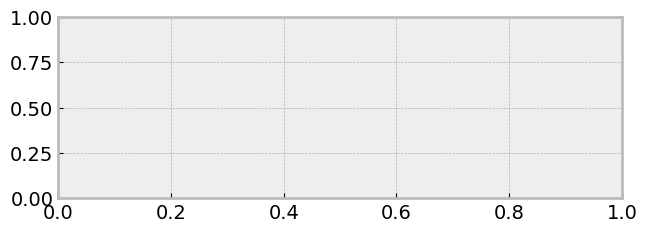

In [ ]:
all_series = {
    #"Временной ряд   International airline passengers ...": airlines_passengers["Count"],
    "Программа долгосрочных сбер": npf_pds["pr_min_pens"]
}

with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)

        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)

    plt.tight_layout()

In [ ]:
len(airlines_passengers) #Длина временного ряда

144

In [ ]:
# 1.Создаем матрицу траекторий
N=144
L = 32 # Длина окна
K = N - L + 1 # Количество столбцов в матрице траекторий
# Создаем матрицу траекторий (Ганкеля)
X = np.column_stack([airlines_passengers['Count'] [i:i+L] for i in range(0,K)])
X

array([[112, 118, 132, ..., 362, 348, 363],
       [118, 132, 129, ..., 348, 363, 435],
       [132, 129, 121, ..., 363, 435, 491],
       ...,
       [178, 199, 199, ..., 606, 508, 461],
       [199, 199, 184, ..., 508, 461, 390],
       [199, 184, 162, ..., 461, 390, 432]])

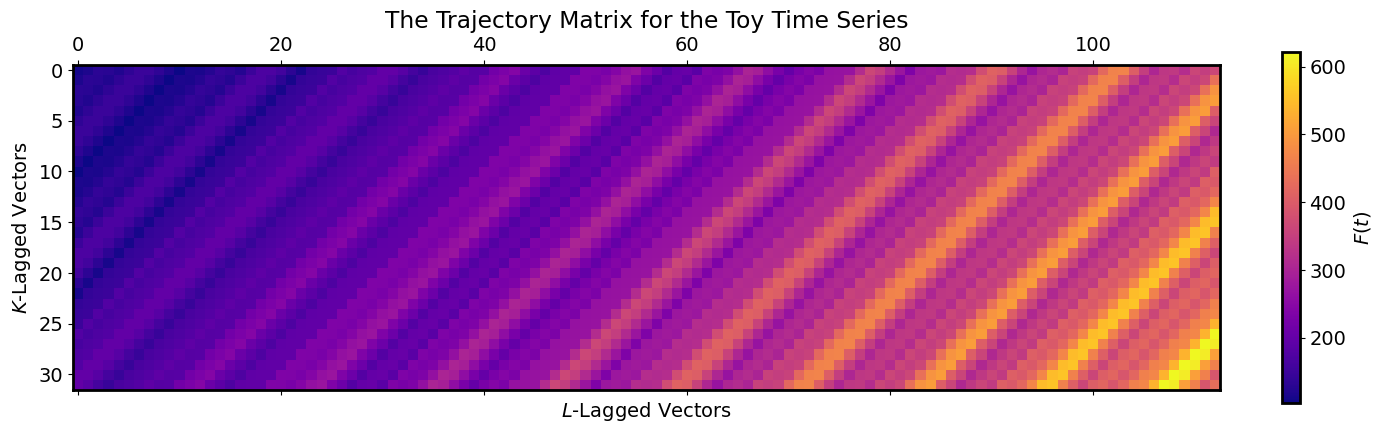

In [ ]:
ax = plt.matshow(X)
plt.xlabel("$L$-Lagged Vectors")
plt.ylabel("$K$-Lagged Vectors")
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label("$F(t)$")
plt.title("The Trajectory Matrix for the Toy Time Series");

In [ ]:
# 2.Разложение матрицы траекторий на сингулярные вектора и значения
d = np.linalg.matrix_rank(X)
U, Sigma, V = np.linalg.svd(X)
V = V.T
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )
if not np.allclose(X, X_elem.sum(axis=0), atol=1e-10):
    print("WARNING: The sum of X's elementary matrices is not equal to X!")

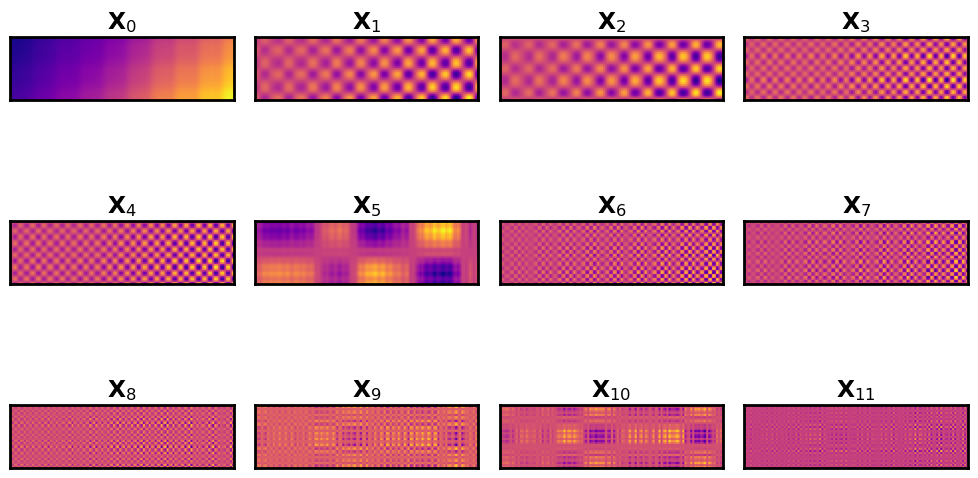

In [ ]:
# 3.Выделение элементов цикла и тенденции из сингулярных векторов из матрицы траектории
# A simple little 2D matrix plotter, excluding x and y labels.
def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

n = min(12, d)  #In case d is less than 12 for the toy series. Say, if we were to exclude the noise component...
for i in range(n):
    plt.subplot(4,4,i+1)
    title = "$\mathbf{X}_{" + str(i) + "}$"
    plot_2d(X_elem[i], title)
plt.tight_layout()

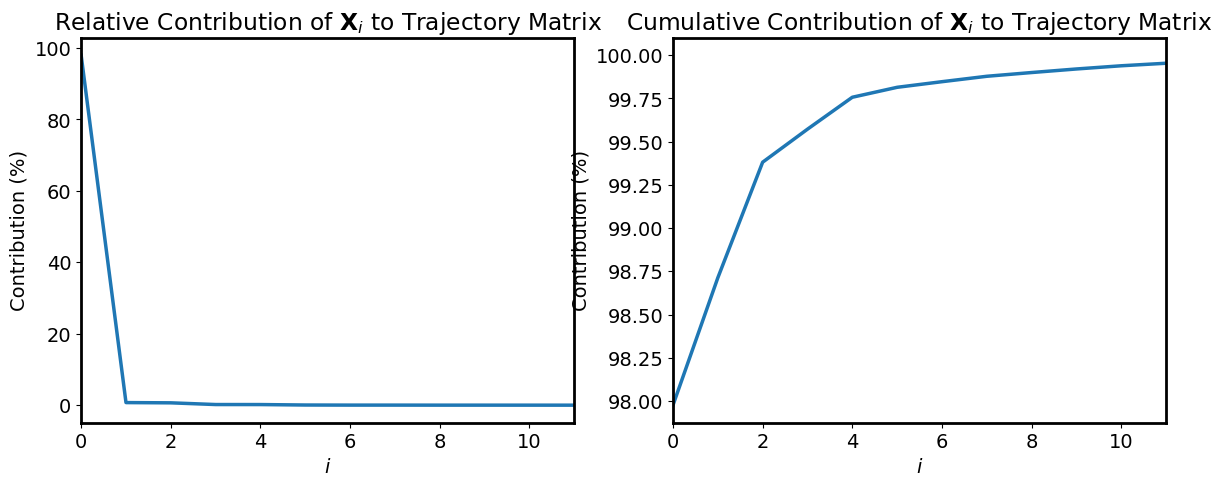

In [ ]:
#4.Реконструкции временных рядов (восстановления тренда и сезонностей, удаление шума)
sigma_sumsq = (Sigma**2).sum()
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].plot(Sigma**2 / sigma_sumsq * 100, lw=2.5)
ax[0].set_xlim(0,11)
ax[0].set_title("Relative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[0].set_xlabel("$i$")
ax[0].set_ylabel("Contribution (%)")
ax[1].plot((Sigma**2).cumsum() / sigma_sumsq * 100, lw=2.5)
ax[1].set_xlim(0,11)
ax[1].set_title("Cumulative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[1].set_xlabel("$i$")
ax[1].set_ylabel("Contribution (%)");

На приведенных выше графиках изображены относительные и кумулятивные вклады первых 12 Xi в разложение X=∑d−1i=0Xi. Элементарная матрицы X0 вносит 98% в разложение X. Вместе первые пять элементарных матриц составляют 99,75%. Элементарные матрицы, которые вносят равный вклад в разложение (то есть σi≈σi+1), вероятно, будут сгруппированы вместе при реконструкции временного ряда, например X1 и X2 должны быть сгруппированы вместе.

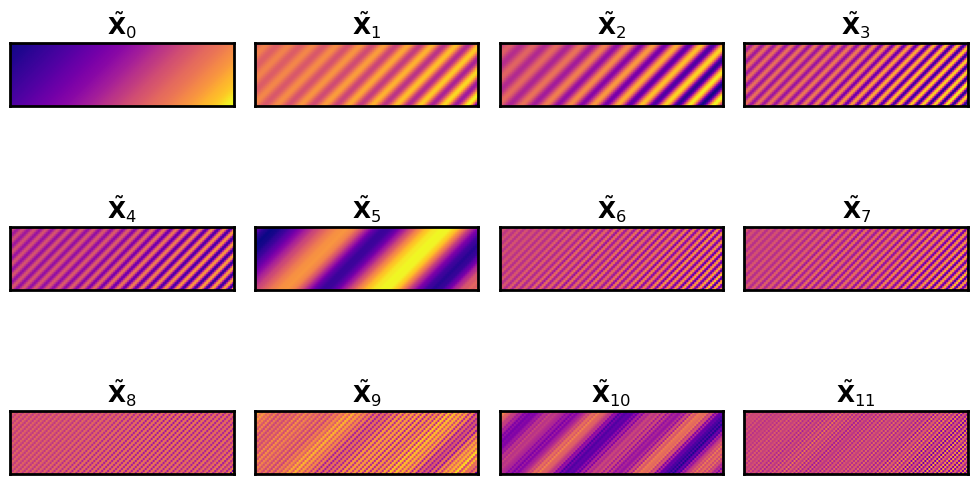

In [ ]:
def Hankelise(X):  #функция формирования матрицы Ганкеля из элементарной матрицы
    """
    Hankelises the matrix X, returning H(X).
    """
    L, K = X.shape
    transpose = False
    if L > K:
        # The Hankelisation below only works for matrices where L < K.
        # To Hankelise a L > K matrix, first swap L and K and tranpose X.
        # Set flag for HX to be transposed before returning.
        X = X.T
        L, K = K, L
        transpose = True

    HX = np.zeros((L,K))

    # I know this isn't very efficient...
    for m in range(L):
        for n in range(K):
            s = m+n
            if 0 <= s <= L-1:
                for l in range(0,s+1):
                    HX[m,n] += 1/(s+1)*X[l, s-l]
            elif L <= s <= K-1:
                for l in range(0,L-1):
                    HX[m,n] += 1/(L-1)*X[l, s-l]
            elif K <= s <= K+L-2:
                for l in range(s-K+1,L):
                    HX[m,n] += 1/(K+L-s-1)*X[l, s-l]
    if transpose:
        return HX.T
    else:
        return HX

n = min(d, 12)
for j in range(0,n):
    plt.subplot(4,4,j+1)
    title = r"$\tilde{\mathbf{X}}_{" + str(j) + "}$"
    plot_2d(Hankelise(X_elem[j]), title)
plt.tight_layout()

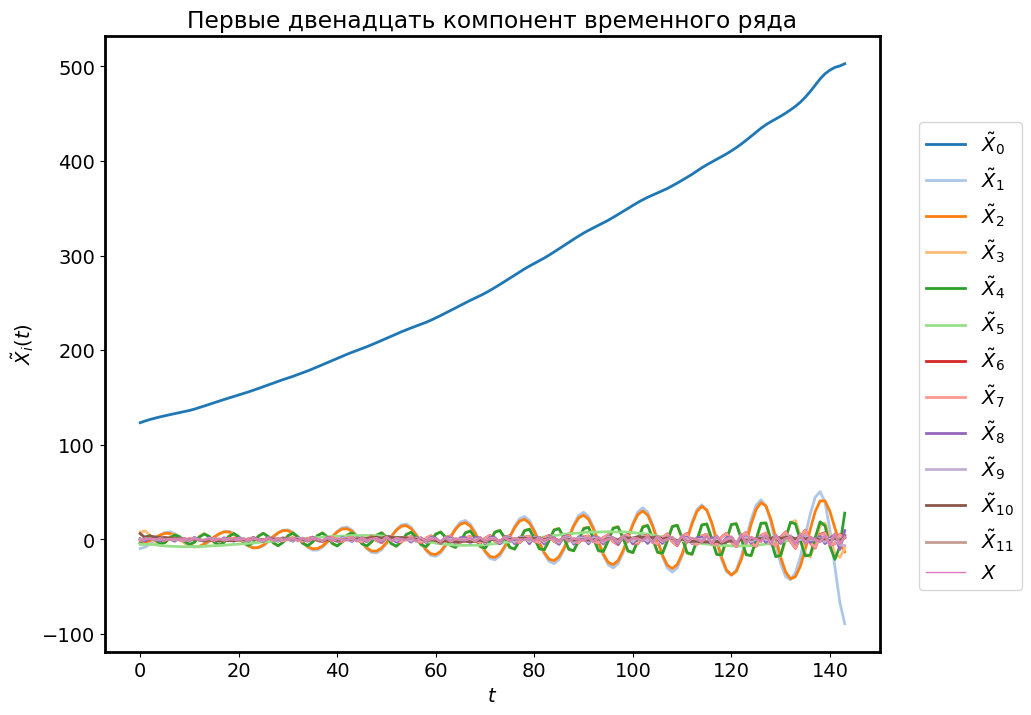

In [ ]:
def X_to_TS(X_i): #Функция усредняет анти-диагонали в заданных елементарных матрицах и  возвращает временные ряды
    # Reverse the column ordering of X_i
    X_rev = X_i[::-1]
    # Full credit to Mark Tolonen at https://stackoverflow.com/a/6313414 for this one:
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])


n = min(12,d) # In case of noiseless time series with d < 12.
t = np.arange(0,N)
# Fiddle with colour cycle - need more colours!
fig = plt.subplot()
color_cycle = cycler(color=plt.get_cmap('tab20').colors)
fig.axes.set_prop_cycle(color_cycle)

# Преобразуем элементарные матрицы сразу во временные ряды
for i in range(n):
    X_i = X_to_TS(X_elem[i])
    fig.axes.plot(t, X_i, lw=2)

fig.axes.plot(t, X_i, alpha=1, lw=1)
fig.set_xlabel("$t$")
fig.set_ylabel(r"$\tilde{X}_i(t)$")
legend = [r"$\tilde{X}_{%s}$" %i for i in range(n)] + ["$X$"]
fig.set_title("Первые двенадцать компонент временного ряда")
fig.legend(legend, loc=(1.05,0.1));

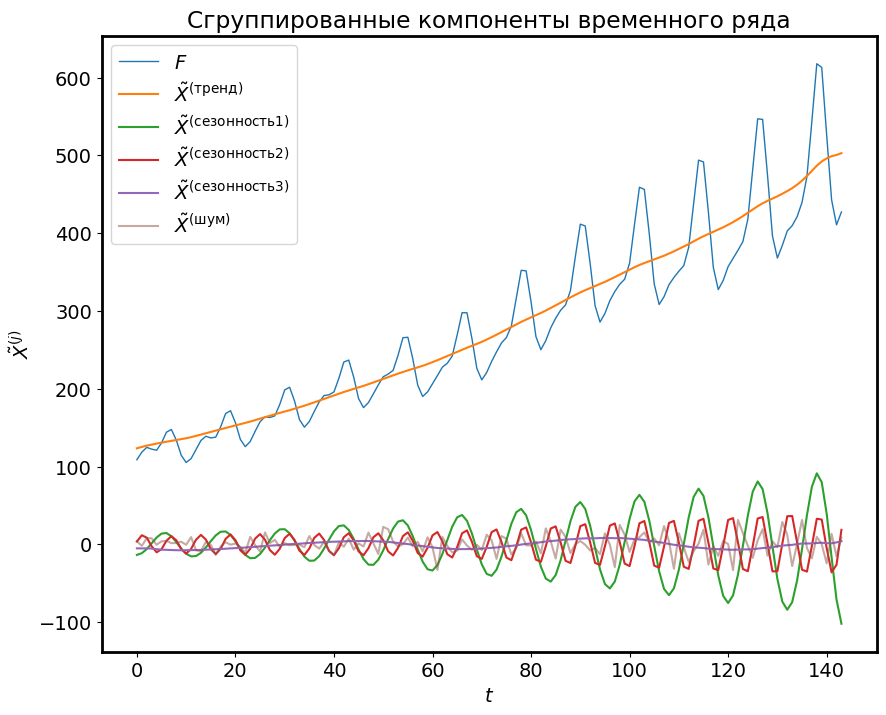

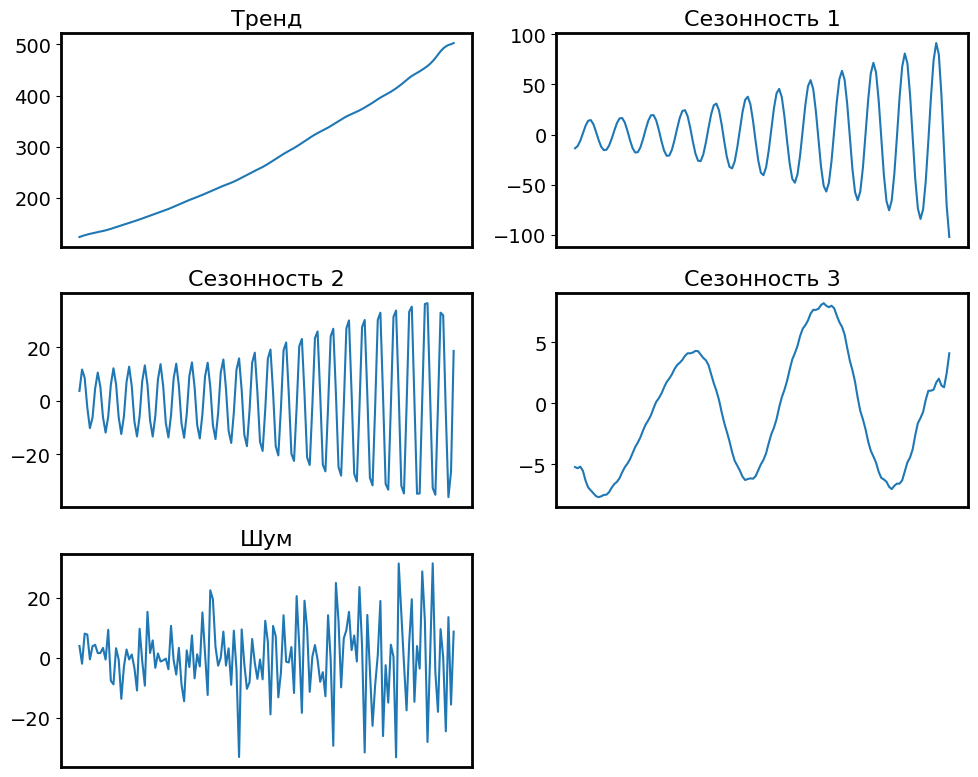

In [ ]:
# Преобразуем сгруппированные компоненты во временные ряды
X_orig=X_to_TS(X_elem[[0,1,2,3,4,5,6]].sum(axis=0))
X_trend = X_to_TS(X_elem[[0]].sum(axis=0))
X_periodic1 = X_to_TS(X_elem[[1,2]].sum(axis=0))
X_periodic2 = X_to_TS(X_elem[[3,4]].sum(axis=0))
X_periodic3 = X_to_TS(X_elem[[5]].sum(axis=0))
X_noise = X_to_TS(X_elem[6:].sum(axis=0))

# Визуализируем временные ряды и показываем основные компоненнты в отдельных окнах
plt.plot(t,X_orig, lw=1)
plt.plot(t, X_trend)
plt.plot(t, X_periodic1)
plt.plot(t, X_periodic2)
plt.plot(t, X_periodic3)
plt.plot(t, X_noise, alpha=0.5)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{X}^{(j)}$")
groups = ["тренд", "сезонность 1", "сезонность 2", "сезонность 3",  "шум"]
legend = ["$F$"] + [r"$\tilde{X}^{(\mathrm{%s})}$"%group for group in groups]
plt.legend(legend)
plt.title("Сгруппированные компоненты временного ряда")
plt.show()

components = [("Тренд",  X_trend),
              ("Сезонность 1", X_periodic1),
              ("Сезонность 2", X_periodic2),
              ("Сезонность 3", X_periodic3),
              ("Шум", X_noise)]

fig = plt.figure()
n=1
for name, ssa_comp in components:
    ax = fig.add_subplot(3,2,n)
    ax.plot(t, ssa_comp)
    ax.set_title(name, fontsize=16)
    ax.set_xticks([])
    n += 1

fig.tight_layout()

In [ ]:
#Для удобства сравнения результатов с разными длинами окон создадим новый класс SSA

class SSA(object):

    __supported_types = (pd.Series, np.ndarray, list)

    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.

        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list.
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.

        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """

        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")

        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")

        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1

        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T

        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)

        self.TS_comps = np.zeros((self.N, self.d))

        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]

            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]

            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."

            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."

        # Calculate the w-correlation matrix.
        self.calc_wcorr()

    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d

        # Create list of columns - call them F0, F1, F2, ...
        cols = ["X{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)


    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.

        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]

        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)

    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """

        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])

        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)

        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5

        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]

    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d

        if self.Wcorr is None:
            self.calc_wcorr()

        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{X}_i$")
        plt.ylabel(r"$\tilde{X}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)

        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max

        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)








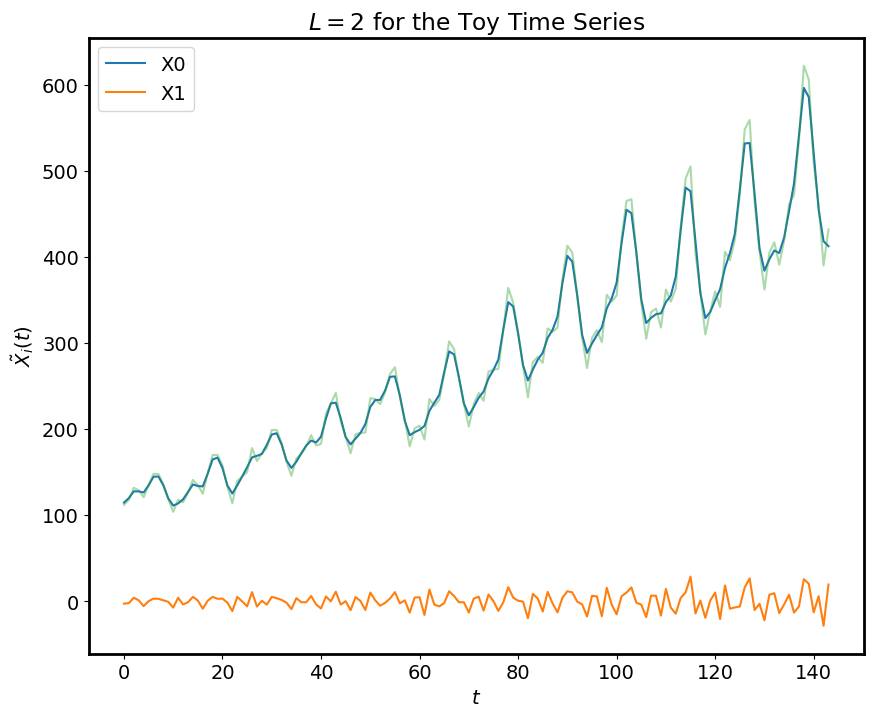

In [ ]:
#Сравним результат с длиной окон 2,8,32
#Окно 2
X_ssa_L2 = SSA(airlines_passengers["Count"], 2)
X_ssa_L2.components_to_df().plot()
X_ssa_L2.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{X}_i(t)$")
plt.title(r"$L=2$ for the Toy Time Series");

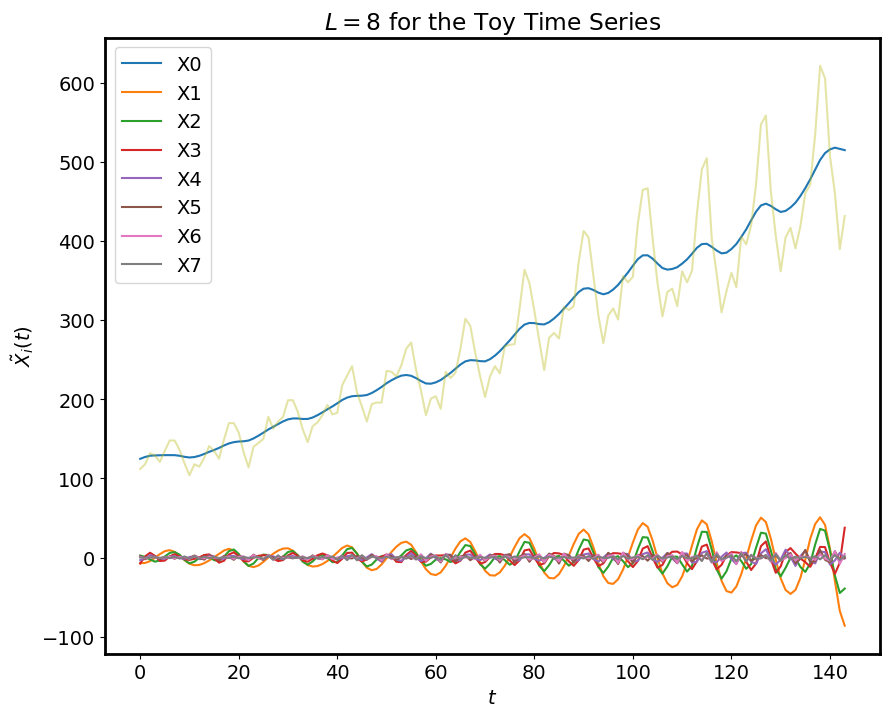

In [ ]:
#Окно 8
X_ssa_L2 = SSA(airlines_passengers["Count"], 8)
X_ssa_L2.components_to_df().plot()
X_ssa_L2.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{X}_i(t)$")
plt.title(r"$L=8$ for the Toy Time Series");

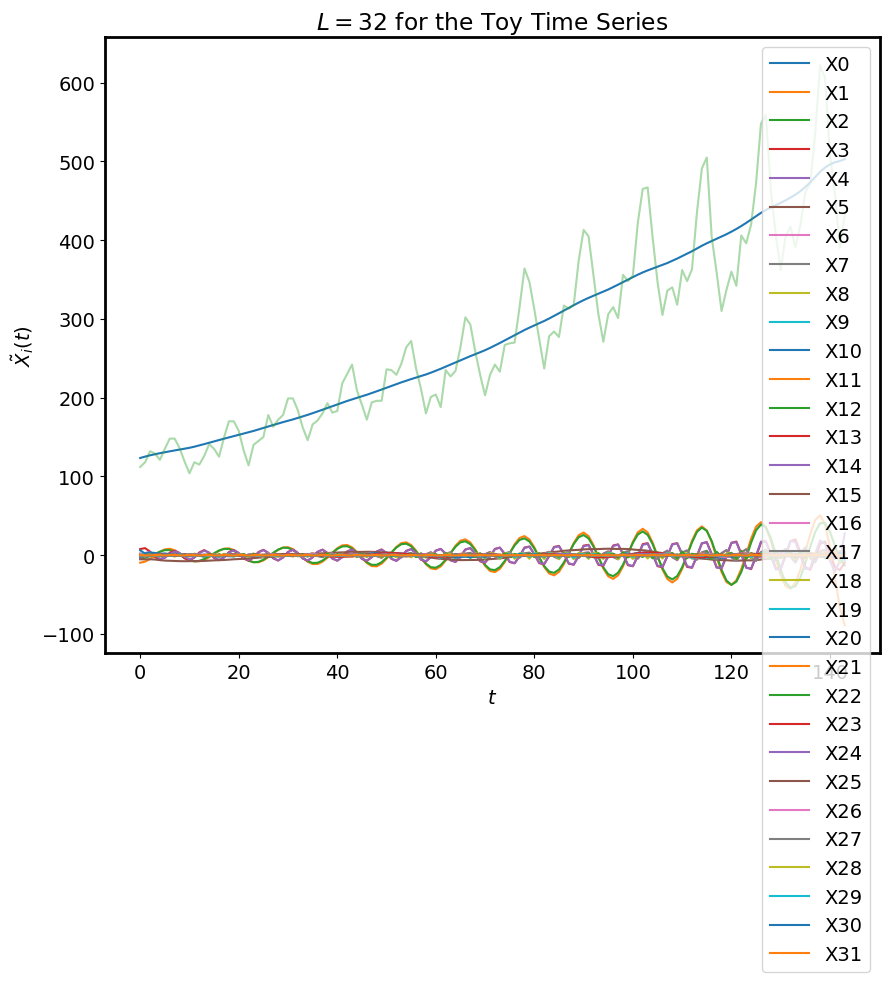

In [ ]:
#Окно 32
X_ssa_L2 = SSA(airlines_passengers["Count"], 32)
X_ssa_L2.components_to_df().plot()
X_ssa_L2.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{X}_i(t)$")
plt.title(r"$L=32$ for the Toy Time Series");

Сравним результаты: С длиной окна 2 не видны основные компоненты: тренда, сезонности. Они проявляются только при длине окна равном 8. При длине окна 32 улучшается линия тренда и видна корреляция между 1 и 2 компонентами.